In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
%matplotlib inline

/Users/nahidalam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from urllib.request import urlretrieve
import zipfile
import collections

## Data Download and Feature Engineering

In [3]:
# Download MovieLens data.
print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [4]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [5]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,0,0,1994,49,M,writer,55105


In [6]:
movielens.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'title',
       'release_date', 'video_release_date', 'imdb_url', 'genre_unknown',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'age', 'sex', 'occupation', 'zip_code'],
      dtype='object')

In [7]:
min_rating = min(movielens["rating"])
max_rating = max(movielens["rating"])

In [8]:
train, test = train_test_split(movielens, test_size=0.1)

In [9]:
ROW_COUNT = train.shape[0]

In [10]:
EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()

In [11]:
train.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
95428,820,124,4.0,874792860,Phenomenon (1996),29-Jun-1996,NaN,http://us.imdb.com/M/title-exact?Phenomenon%20...,0,0,...,1,0,0,0,0,1996,37,M,engineer,77845
94460,755,49,4.0,874828592,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,...,1,1,0,1,0,1977,30,F,none,90247
87153,828,639,3.0,881707829,"Cook the Thief His Wife & Her Lover, The (1989)",01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Cook%20the%20...,0,0,...,0,0,0,0,0,1989,48,M,writer,80209
70656,649,451,2.0,891370155,Jaws 2 (1978),01-Jan-1978,NaN,http://us.imdb.com/M/title-exact?Jaws%202%20(1...,0,1,...,0,0,0,0,0,1978,42,M,engineer,83814
47589,6,388,4.0,891354090,Black Beauty (1994),01-Jan-1994,NaN,http://us.imdb.com/Title?Black+Beauty+(1994/I),0,0,...,0,0,0,0,0,1994,57,M,administrator,91344


In [12]:
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

### Define the model
We are defining a four layer Deep Neural Network. The model has two sub-models inside - `movie_model` and `user_model`. We define them so that once the model is trained, we can extract corresponsing movie or user embedding through these sub-models respectively. 

In [13]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [14]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

### Train the model

In [15]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Train on 90000 samples, validate on 10000 samples
Epoch 1/50
90000/90000 [==============================] - 4s 46us/sample - loss: 1.0642 - val_loss: 0.9516
Epoch 2/50
90000/90000 [==============================] - 3s 35us/sample - loss: 0.9473 - val_loss: 0.9576
Epoch 3/50
90000/90000 [==============================] - 3s 34us/sample - loss: 0.9257 - val_loss: 0.9236
Epoch 4/50
90000/90000 [==============================] - 3s 35us/sample - loss: 0.8168 - val_loss: 0.7874
Epoch 5/50
90000/90000 [==============================] - 3s 35us/sample - loss: 0.7238 - val_loss: 0.7829
Epoch 6/50
90000/90000 [==============================] - 3s 33us/sample - loss: 0.6868 - val_loss: 0.7635
Epoch 7/50
90000/90000 [==============================] - 3s 34us/sample - loss: 0.6654 - val_loss: 0.7659
Epoch 8/50
90000/90000 [==============================] - 3s 33us/sample - loss: 0.6500 - val_loss: 0.7695
Epoch 9/50
90000/90000 [==============================] - 3s 34us/sample - loss: 0.6399 - val_

In [16]:
# checkout a sample user embedding
user_model.predict([np.array([10]), np.array([3])])

array([[-0.33259192,  0.24012446, -0.03351335, -0.03064746, -0.11586254,
         0.02682596,  0.07215138,  0.06854121,  0.02979331, -0.17519705]],
      dtype=float32)

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 10)        16820       movie_id[0][0]                   
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 10)        9430        user_id[0][0]                    
____________________________________________________________________________________________

### Visualize the model architecture

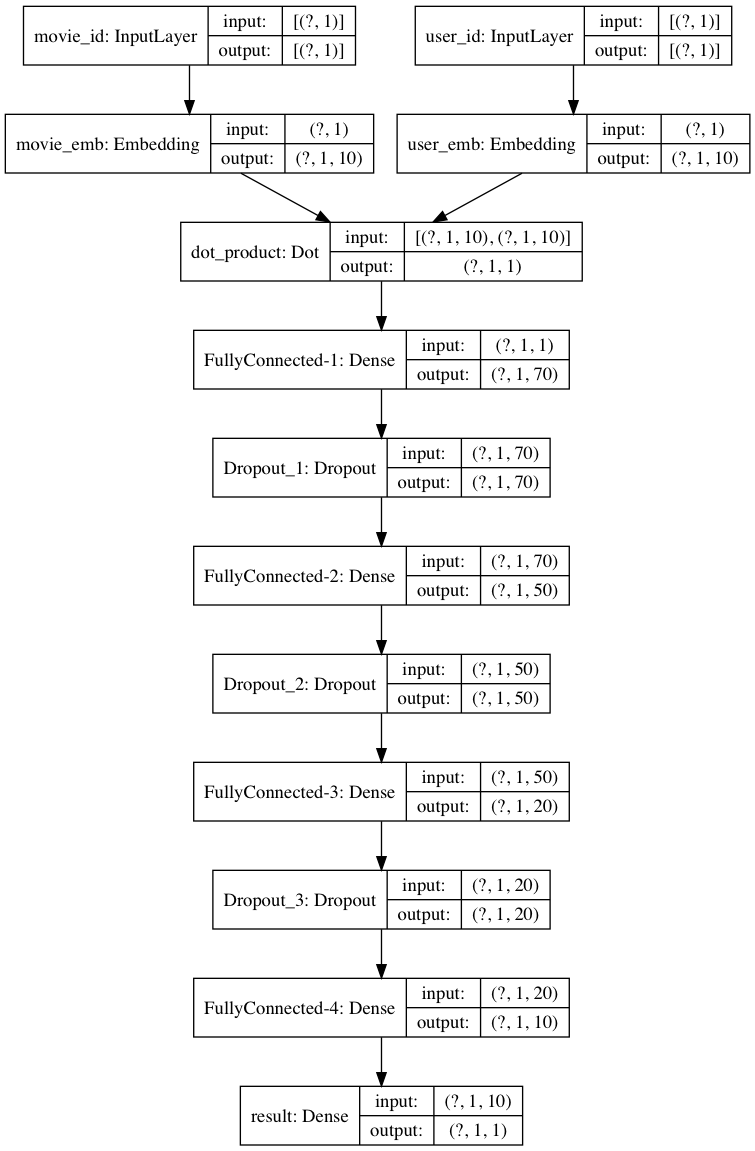

In [18]:
keras.utils.plot_model(model, show_shapes=True)

### Plot the Loss Curve

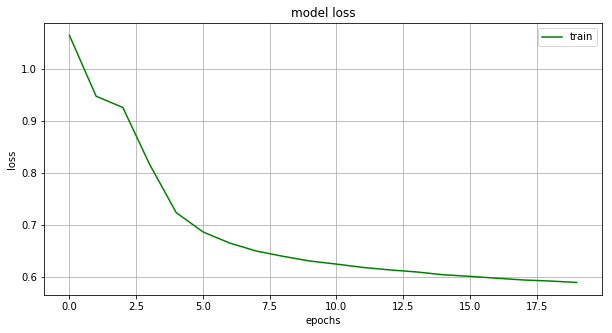

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

## How do we interpret this model?

We observe that the training loss decreases over epochs which means that the training is converging to an optimal point.

## Nearest Neighbor Recommendation

In [20]:
TEST_USER_ID = 200
TEST_MOVIE_ID = 123

## Extract Movie embedding

In [21]:
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

In [22]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

## Verify Embeddings
How do we know that these embeddings are correct? One way to verify them is to plot those embeddings. Once you plot, you will see that movies with a similar rating (as the rating was our target) are close by in the embedding space. Let's have a look.


In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def tsne_plot(model, MOVIE_EMBEDDING_LIST, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()
    

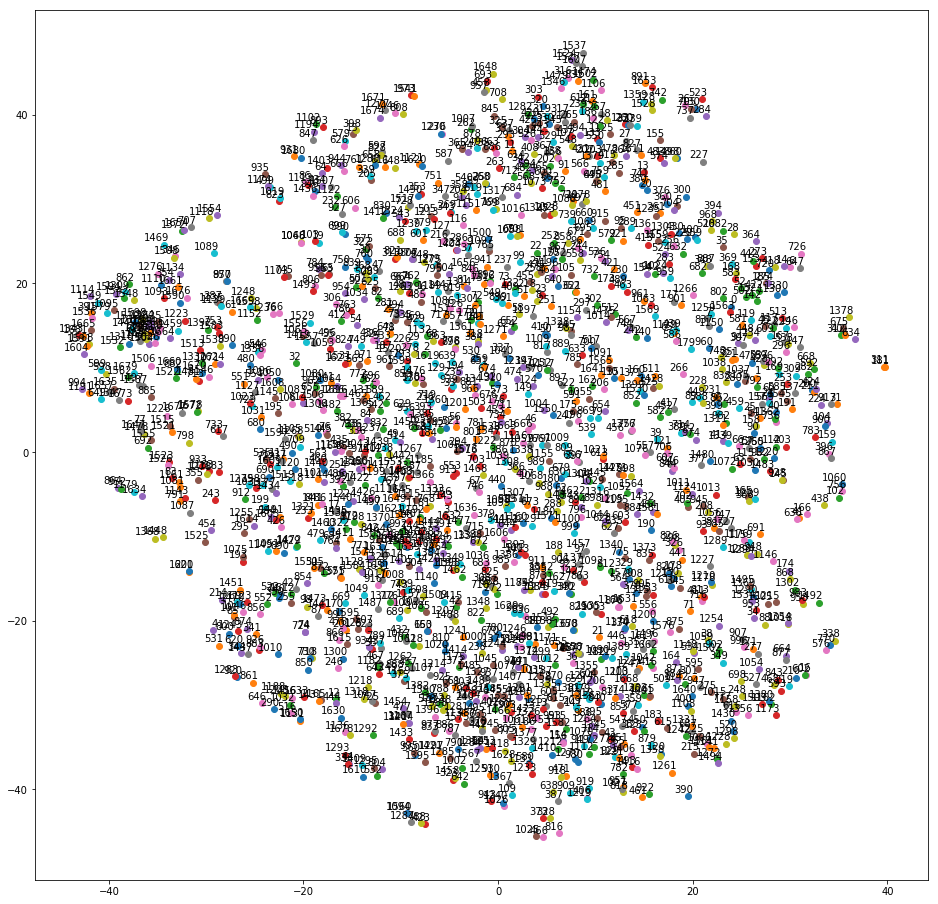

In [25]:
tsne_plot(model, MOVIE_EMBEDDING_LIST)

The above figure is a little hard to visualize. So I am going to plot the 1st 300 movie embeddings to check if I can get a clearer picture.

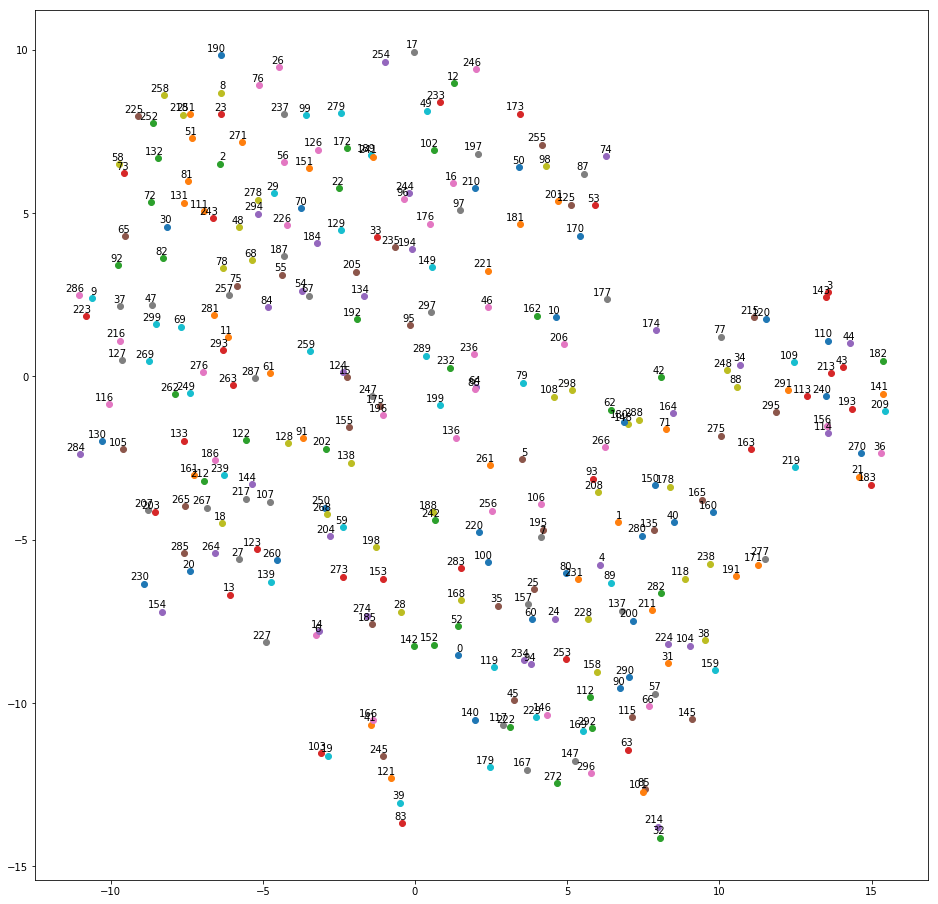

In [26]:
tsne_plot(model, MOVIE_EMBEDDING_LIST, 300)

Let's see how the average rating for movie id `53`, `66` and `9` looks like. From the above figure, movie id `53` and `66` should have similar rating than movie id `9`.

In [27]:
np.average(movielens.loc[movielens['movie_id'] == 53, 'rating'], axis=0)

3.2403846153846154

In [28]:
np.average(movielens.loc[movielens['movie_id'] == 66, 'rating'], axis=0)

3.0485436893203883

In [29]:
np.average(movielens.loc[movielens['movie_id'] == 9, 'rating'], axis=0)

3.831460674157303

## Top-K Candidates using K-Nearest Neighbor

Now that we have the embeddings, we can apply the nearest neighbor algorithm to recommend movies to users. We can get `user_embedding` from the `user_id` and find out what are the movies that are close to the `user_embedding` in the embedding space. We use K-Nearest Neighbor algorithm for this purpose.

In [30]:
knn_train_label = UNIQUE_MOVIE_IDS

In [31]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [32]:
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']
    

In [33]:
TEST_USER_ID

200

In [34]:
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]

In [35]:
recommend_movies(user_embedding)

0       Man Without a Face, The (1993)
1                      Liebelei (1933)
2                          Nell (1994)
3                          Cosi (1996)
4                          Ripe (1996)
5              Escape from L.A. (1996)
6                      Shopping (1994)
7              Tough and Deadly (1995)
8    Destiny Turns on the Radio (1995)
9                 Losing Isaiah (1995)
Name: title, dtype: object